In [1]:
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torchinfo

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset

In [2]:
def create_dataloader(dataset, transform=None, val_split=0.25, batch_size=64, num_workers=2):
    train_set = dataset('./data', train=True,  download=True, transform=transform)
    test_set  = dataset('./data', train=False, download=True, transform=transform)
    
    train_set, val_set = torch.utils.data.random_split(train_set, [1-val_split, val_split])
    
    train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val   = torch.utils.data.DataLoader(val_set,   batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    test  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return (train, val, test)

# Create model

## Gradient Reversal Layer

In [3]:
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

## CNN

In [4]:
class DomainClassifier(nn.Module):
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        
        self.projection = nn.Linear(in_features, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=1), num_layers=1
        )
        self.op_layer = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.projection(x)
        x = self.transformer(x)[0, :]
        x = self.op_layer(x)
        return x

In [5]:
class MyModel(nn.Module):
    def __init__(
        self,
        input_shape:       Tuple[int],
        output_shape:      int,
        cnn_out_features:  List[int],
        fnn_out_features:  List[int],
        batch_size:        int,
    ):
        super().__init__()
        
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.cnn_layers = nn.ModuleList()
        self.fnn_layers = nn.ModuleList()
        
        shape = list(input_shape)
        prev_nf = input_shape[0]
        
        i = 0
        for curr_nf in cnn_out_features:
            self.cnn_layers.append(nn.Sequential(
                nn.Conv2d(prev_nf, curr_nf, kernel_size=3, padding='same'),
                nn.MaxPool2d(2)
            ))
            prev_nf = curr_nf
            
            shape[0] = curr_nf
            shape[1] = int(shape[1] / 2)
            shape[2] = int(shape[2] / 2)
        
        prev_nf = shape[0] * shape[1] * shape[2]
        
        self.domain_classifier = DomainClassifier(prev_nf, hidden_size=128)
        
        for curr_nf in fnn_out_features:
            self.fnn_layers.append(nn.Sequential(
                nn.Linear(prev_nf, curr_nf),
                nn.ReLU()
            ))
            prev_nf = curr_nf
        
        self.op_layer = nn.Sequential(nn.Linear(prev_nf, output_shape))
    
    def forward(self, xs: torch.Tensor, xt: torch.Tensor, alpha: float) -> Tuple[torch.Tensor]:
        for layer in self.cnn_layers:
            xs = layer(xs)
            xt = layer(xt)
        xs = torch.flatten(xs, start_dim=1)
        xt = torch.flatten(xt, start_dim=1)
        
        xs_reverse = ReverseLayerF.apply(xs, alpha)
        ys_domain = self.domain_classifier(xs_reverse)
        
        xt_reverse = ReverseLayerF.apply(xt, alpha)
        yt_domain = self.domain_classifier(xt_reverse)
        
        for layer in self.fnn_layers:
            xs = layer(xs)
            xt = layer(xt)
        
        ys_class = xs
        yt_class = xt
        return (ys_class, ys_domain, yt_class, yt_domain)

## Customized loss

In [6]:
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dummy_param = nn.Parameter(torch.empty(0))
        self.loss_class  = nn.CrossEntropyLoss()
        self.loss_domain = nn.BCELoss()
    
    def forward(self, ys_class, ys_class_true, ys_domain, yt_domain):
        ys_domain_true = torch.zeros(1, device=self.dummy_param.device)
        yt_domain_true = torch.ones(1, device=self.dummy_param.device)
        
        loss_s_class  = self.loss_class(ys_class, ys_class_true)
        loss_s_domain = self.loss_domain(ys_domain, ys_domain_true)
        loss_t_domain = self.loss_domain(yt_domain, yt_domain_true)
        
        loss = loss_s_class + loss_s_domain + loss_t_domain
        return (loss, loss_s_class, loss_s_domain, loss_t_domain)

# Training & evaluation

In [7]:
def evaluate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    mode: str = None,
):
    model.eval()
    val_losses = []
    val_class_losses  = []
    val_domain_losses = []
    val_pt = []
    accuracy = 0
    
    with torch.no_grad():
        for batch_idx, (x, y_true) in enumerate(dataloader):
            x = x.to(device)
            y_true = y_true.to(device)
            
            if x.shape[0] != batch_size:
                continue
            
            ys_class, ys_domain, yt_class, yt_domain = model(x, x, 0)
            y_pred = ys_class
            loss, loss_s_class, loss_s_domain, loss_t_domain = loss_fn(y_pred, y_true, ys_domain, yt_domain)
            
            val_losses += [loss.item()]
            val_class_losses  += [loss_s_class.item()]
            val_domain_losses += [loss_s_domain.item()]
            val_pt += [ys_domain.item()]
            
            y_pred1 = torch.max(y_pred, dim=1)[1]
            accuracy += torch.sum(y_pred1 == y_true).item()
    
    accuracy /= len(dataloader.dataset)
    loss        = np.mean(val_losses)
    class_loss  = np.mean(val_class_losses)
    domain_loss = np.mean(val_domain_losses)
    
    if mode is not None:
        print('{} -> loss: {:.6f}\tloss_class: {:.6f}\tloss_domain: {:.6f}\tp(t|x): {:.6f}\taccuracy: {:.4f}%'.format(
            mode,
            loss,
            class_loss,
            domain_loss,
            ys_domain.item(),
            accuracy * 100
        ))
    return (loss, class_loss, domain_loss, accuracy)

In [8]:
def train(
    model: nn.Module,
    dataloader_s: torch.utils.data.DataLoader,
    dataloader_t: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch:      int,
    num_epochs: int,
    checkpoint: int = None
):
    model.train()
    losses = []
    losses_s_class  = []
    losses_s_domain = []
    losses_t_domain = []
    
    len_dataloader = min(len(dataloader_s), len(dataloader_t))
    iter_s = iter(dataloader_s)
    iter_t = iter(dataloader_t)

    for batch_idx in range(len_dataloader):
        p = float(batch_idx + epoch * len_dataloader) / num_epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        data_s = next(iter_s)
        data_t = next(iter_t)

        xs, ys_true = data_s
        xt, yt_true = data_t
        xs = xs.to(device)
        xt = xt.to(device)
        ys_true = ys_true.to(device)
        yt_true = yt_true.to(device)

        ys_class, ys_domain, yt_class, yt_domain = model(xs, xt, alpha)
        loss, loss_s_class, loss_s_domain, loss_t_domain = loss_fn(ys_class, ys_true, ys_domain, yt_domain)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += [loss.item()]
        losses_s_class  += [loss_s_class.item()]
        losses_s_domain += [loss_s_domain.item()]
        losses_t_domain += [loss_t_domain.item()]

        if checkpoint is not None and batch_idx % checkpoint == 0:
            print('Train -> [{:>5}/{:>5} ({:.0f}%)]\tloss: {:.6f}\tloss_s_class: {:.6f}\tloss_domain: {:.6f}+{:.6f}\tp(t|s): {:.6f}\tp(t|t): {:.6f}'.format(
                batch_idx * dataloader_s.batch_size,
                len_dataloader * dataloader_s.batch_size,
                batch_idx / len_dataloader * 100,
                loss.item(),
                loss_s_class.item(),
                loss_s_domain.item(),
                loss_t_domain.item(),
                ys_domain.item(),
                yt_domain.item()
            ))
    
    loss = np.mean(losses)
    loss_s_class  = np.mean(losses_s_class)
    loss_s_domain = np.mean(losses_s_domain)
    loss_t_domain = np.mean(losses_t_domain)
    
    return (loss, loss_s_class, loss_s_domain, loss_t_domain)

# Plotting

In [9]:
def plot_losses(
    losses: List[np.ndarray],
    labels: List[str] = None,
    ylabel: str = '',
    xlabel: str = '',
    title:  str = ''
):
    if labels is None:
        labels = [''] * len(losses)
    for loss, label in zip(losses, labels):
        plt.plot(loss, label=label)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

# Main

In [10]:
lr         = 1e-3
batch_size = 128
num_epochs = 100
checkpoint = 100
model_save_path = 'best_model.pt'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_s, val_s, test_s = create_dataloader(
    torchvision.datasets.MNIST,
    transform=transform,
    batch_size=batch_size
)
train_t, val_t, test_t = create_dataloader(
    torchvision.datasets.USPS,
    transform=transforms.Compose([transform, transforms.Resize((28, 28))]),
    batch_size=batch_size
)

In [11]:
# img_s = next(iter(train_s))[0][0]
# print(img_s.shape)
# plt.imshow(img_s[0], cmap='gray')
# plt.show()

# img_t = next(iter(train_t))[0][0]
# print(img_t.shape)
# plt.imshow(img_t[0], cmap='gray')
# plt.show()

In [12]:
model = MyModel(
    input_shape=(1, 28, 28),
    output_shape=10,
    cnn_out_features=[16, 32, 64],
    fnn_out_features=[128, 64],
    batch_size=batch_size
).to(device)

loss_fn    = MyLoss().to(device)
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = [[], [], [], []]
val_s_losses = [[], [], [], []]
val_t_losses = [[], [], [], []]
train_loss_labels  = ['loss', 'loss_s_class', 'loss_s_domain', 'loss_t_domain']
val_loss_labels    = ['loss', 'loss_class', 'loss_domain', 'accuracy']

In [13]:
torchinfo.summary(
    model,
    input_size=[(batch_size, 1, 28, 28), (batch_size, 1, 28, 28), (1,)]
)

Layer (type:depth-idx)                             Output Shape              Param #
MyModel                                            [128, 64]                 650
├─ModuleList: 1-1                                  --                        --
│    └─Sequential: 2-1                             [128, 16, 14, 14]         --
│    │    └─Conv2d: 3-1                            [128, 16, 28, 28]         160
│    │    └─MaxPool2d: 3-2                         [128, 16, 14, 14]         --
│    └─Sequential: 2-2                             [128, 16, 14, 14]         (recursive)
│    │    └─Conv2d: 3-3                            [128, 16, 28, 28]         (recursive)
│    │    └─MaxPool2d: 3-4                         [128, 16, 14, 14]         --
│    └─Sequential: 2-3                             [128, 32, 7, 7]           --
│    │    └─Conv2d: 3-5                            [128, 32, 14, 14]         4,640
│    │    └─MaxPool2d: 3-6                         [128, 32, 7, 7]           --
│    └─Seque

In [14]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} --------')
    
    losses = train(model, train_s, train_t, loss_fn, optimizer, epoch, num_epochs, checkpoint=20)
    for i, loss in enumerate(losses):
        train_losses[i] += [loss]
    
    losses = evaluate(model, val_s, loss_fn, mode='Validation (source)')
    for i, loss in enumerate(losses):
        val_s_losses[i] += [loss]
    
    losses = evaluate(model, val_t, loss_fn, mode='Validation (target)')
    for i, loss in enumerate(losses):
        val_t_losses[i] += [loss]
    
    if losses[1] < best_val_loss:
        torch.save(model.state_dict(), model_save_path)
        best_val_loss = losses[1]
        print(f'Best model updated and saved at "{model_save_path}"')

Epoch 1 --------
Train -> [    0/ 5504 (0%)]	loss: 5.726105	loss_s_class: 4.138095	loss_domain: 0.419061+1.168949	p(t|s): 0.342336	p(t|t): 0.310693
Train -> [ 2560/ 5504 (47%)]	loss: 3.242281	loss_s_class: 3.076758	loss_domain: 0.150452+0.015071	p(t|s): 0.139681	p(t|t): 0.985042
Train -> [ 5120/ 5504 (93%)]	loss: 2.156726	loss_s_class: 2.150900	loss_domain: 0.002534+0.003292	p(t|s): 0.002531	p(t|t): 0.996713
Validation (source) -> loss: 8.283817	loss_class: 2.078075	loss_domain: 0.002026	p(t|x): 0.002075	accuracy: 55.4333%
Validation (target) -> loss: 7.586738	loss_class: 2.312966	loss_domain: 5.255174	p(t|x): 0.997634	accuracy: 43.2492%
Best model updated and saved at "best_model.pt"
Epoch 2 --------
Train -> [    0/ 5504 (0%)]	loss: 1.907381	loss_s_class: 1.902241	loss_domain: 0.002447+0.002693	p(t|s): 0.002444	p(t|t): 0.997311
Train -> [ 2560/ 5504 (47%)]	loss: 2.285958	loss_s_class: 1.341969	loss_domain: 0.941551+0.002437	p(t|s): 0.609978	p(t|t): 0.997566
Train -> [ 5120/ 5504 (93%

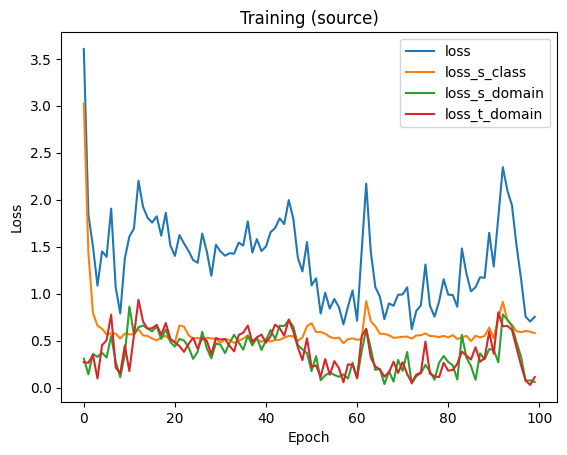

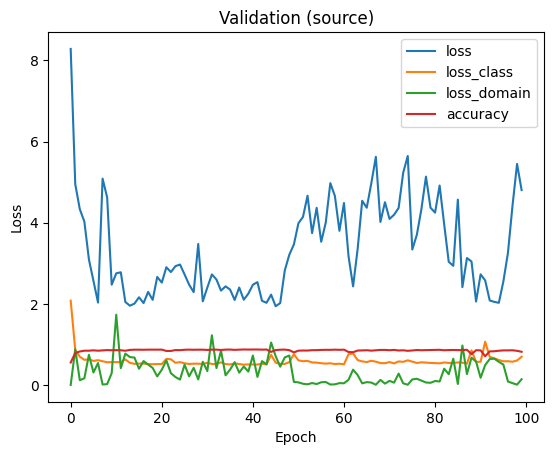

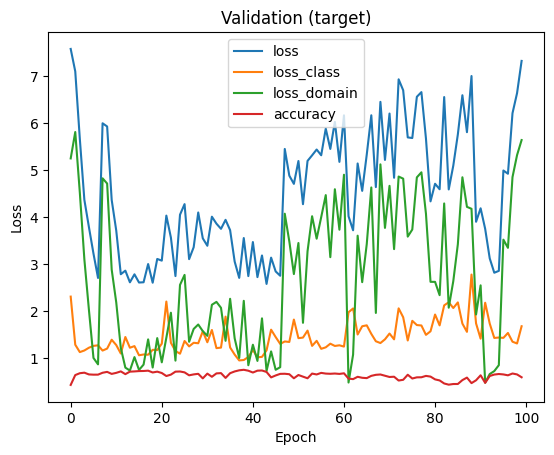

In [15]:
plot_losses(
    train_losses,
    train_loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Training (source)'
)
plot_losses(
    val_s_losses,
    val_loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation (source)'
)
plot_losses(
    val_t_losses,
    val_loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation (target)'
)

In [16]:
model.load_state_dict(torch.load(model_save_path))
evaluate(model, test_s, loss_fn, mode='Test (source)')
evaluate(model, test_t, loss_fn, mode='Test (target)')

Test (source) -> loss: 2.416480	loss_class: 0.509896	loss_domain: 0.305714	p(t|x): 0.105247	accuracy: 87.4800%
Test (target) -> loss: 3.332139	loss_class: 1.040603	loss_domain: 1.661248	p(t|x): 0.305700	accuracy: 71.9482%


(3.332138522466024, 1.0406026403109232, 1.661247851451238, 0.7194818136522172)